![alt text](http://www.kisbu.edu.tr/wp-content/uploads/2018/05/kharazmi.png)


![alt text](http://s8.picofile.com/file/8349878250/download.png)

# MNIST Dinoising by Convolutional Auto Encoder

using Keras Library (Tensorflow Backend)


Researchers:

***Ali Forghani ElahAbadi  ***



DIP Workshop in Kharazmi University, 
Tehran, IRAN


## 1. Import important library

numpy to manage arrays and matrixes

matplot to show and plot image and diagram

pandas to work with csv and other files


random seed to keep the random generator function

and mnist dataset

In [0]:

from IPython import get_ipython
get_ipython().magic('reset -sf')

%config IPCcompeleter.greedy = True

import tensorflow 
import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(400)


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

## 2.Noise Generator Function 

to generate Salt&pepper, Gaussian, Poisson, Speckle Noise


this function from other refrences


In [0]:
import numpy as np
from skimage import img_as_float


__all__ = ['random_noise']


def random_noise(image, mode='gaussian', seed=None, clip=True, **kwargs):
    """
    Function to add random noise of various types to a floating-point image.
    Parameters
    ----------
    image : ndarray
        Input image data. Will be converted to float.
    mode : str, optional
        One of the following strings, selecting the type of noise to add:
        - 'gaussian'  Gaussian-distributed additive noise.
        - 'localvar'  Gaussian-distributed additive noise, with specified
                      local variance at each point of `image`.
        - 'poisson'   Poisson-distributed noise generated from the data.
        - 'salt'      Replaces random pixels with 1.
        - 'pepper'    Replaces random pixels with 0 (for unsigned images) or
                      -1 (for signed images).
        - 's&p'       Replaces random pixels with either 1 or `low_val`, where
                      `low_val` is 0 for unsigned images or -1 for signed
                      images.
        - 'speckle'   Multiplicative noise using out = image + n*image, where
                      n is uniform noise with specified mean & variance.
    seed : int, optional
        If provided, this will set the random seed before generating noise,
        for valid pseudo-random comparisons.
    clip : bool, optional
        If True (default), the output will be clipped after noise applied
        for modes `'speckle'`, `'poisson'`, and `'gaussian'`. This is
        needed to maintain the proper image data range. If False, clipping
        is not applied, and the output may extend beyond the range [-1, 1].
    mean : float, optional
        Mean of random distribution. Used in 'gaussian' and 'speckle'.
        Default : 0.
    var : float, optional
        Variance of random distribution. Used in 'gaussian' and 'speckle'.
        Note: variance = (standard deviation) ** 2. Default : 0.01
    local_vars : ndarray, optional
        Array of positive floats, same shape as `image`, defining the local
        variance at every image point. Used in 'localvar'.
    amount : float, optional
        Proportion of image pixels to replace with noise on range [0, 1].
        Used in 'salt', 'pepper', and 'salt & pepper'. Default : 0.05
    salt_vs_pepper : float, optional
        Proportion of salt vs. pepper noise for 's&p' on range [0, 1].
        Higher values represent more salt. Default : 0.5 (equal amounts)
    Returns
    -------
    out : ndarray
        Output floating-point image data on range [0, 1] or [-1, 1] if the
        input `image` was unsigned or signed, respectively.
    Notes
    -----
    Speckle, Poisson, Localvar, and Gaussian noise may generate noise outside
    the valid image range. The default is to clip (not alias) these values,
    but they may be preserved by setting `clip=False`. Note that in this case
    the output may contain values outside the ranges [0, 1] or [-1, 1].
    Use this option with care.
    Because of the prevalence of exclusively positive floating-point images in
    intermediate calculations, it is not possible to intuit if an input is
    signed based on dtype alone. Instead, negative values are explicitly
    searched for. Only if found does this function assume signed input.
    Unexpected results only occur in rare, poorly exposes cases (e.g. if all
    values are above 50 percent gray in a signed `image`). In this event,
    manually scaling the input to the positive domain will solve the problem.
    The Poisson distribution is only defined for positive integers. To apply
    this noise type, the number of unique values in the image is found and
    the next round power of two is used to scale up the floating-point result,
    after which it is scaled back down to the floating-point image range.
    To generate Poisson noise against a signed image, the signed image is
    temporarily converted to an unsigned image in the floating point domain,
    Poisson noise is generated, then it is returned to the original range.
    """
    mode = mode.lower()

    # Detect if a signed image was input
    if image.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.

    image = img_as_float(image)
    if seed is not None:
        np.random.seed(seed=seed)

    allowedtypes = {
        'gaussian': 'gaussian_values',
        'localvar': 'localvar_values',
        'poisson': 'poisson_values',
        'salt': 'sp_values',
        'pepper': 'sp_values',
        's&p': 's&p_values',
        'speckle': 'gaussian_values'}

    kwdefaults = {
        'mean': 0.,
        'var': 0.01,
        'amount': 0.05,
        'salt_vs_pepper': 0.5,
        'local_vars': np.zeros_like(image) + 0.01}

    allowedkwargs = {
        'gaussian_values': ['mean', 'var'],
        'localvar_values': ['local_vars'],
        'sp_values': ['amount'],
        's&p_values': ['amount', 'salt_vs_pepper'],
        'poisson_values': []}

    for key in kwargs:
        if key not in allowedkwargs[allowedtypes[mode]]:
            raise ValueError('%s keyword not in allowed keywords %s' %
                             (key, allowedkwargs[allowedtypes[mode]]))

    # Set kwarg defaults
    for kw in allowedkwargs[allowedtypes[mode]]:
        kwargs.setdefault(kw, kwdefaults[kw])

    if mode == 'gaussian':
        noise = np.random.normal(kwargs['mean'], kwargs['var'] ** 0.5,
                                 image.shape)
        out = image + noise

    elif mode == 'localvar':
        # Ensure local variance input is correct
        if (kwargs['local_vars'] <= 0).any():
            raise ValueError('All values of `local_vars` must be > 0.')

        # Safe shortcut usage broadcasts kwargs['local_vars'] as a ufunc
        out = image + np.random.normal(0, kwargs['local_vars'] ** 0.5)

    elif mode == 'poisson':
        # Determine unique values in image & calculate the next power of two
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))

        # Ensure image is exclusively positive
        if low_clip == -1.:
            old_max = image.max()
            image = (image + 1.) / (old_max + 1.)

        # Generating noise for each unique value in image.
        out = np.random.poisson(image * vals) / float(vals)

        # Return image to original range if input was signed
        if low_clip == -1.:
            out = out * (old_max + 1.) - 1.

    elif mode == 'salt':
        # Re-call function with mode='s&p' and p=1 (all salt noise)
        out = random_noise(image, mode='s&p', seed=seed,
                           amount=kwargs['amount'], salt_vs_pepper=1.)

    elif mode == 'pepper':
        # Re-call function with mode='s&p' and p=1 (all pepper noise)
        out = random_noise(image, mode='s&p', seed=seed,
                           amount=kwargs['amount'], salt_vs_pepper=0.)

    elif mode == 's&p':
        out = image.copy()
        p = kwargs['amount']
        q = kwargs['salt_vs_pepper']
        flipped = np.random.choice([True, False], size=image.shape,
                                   p=[p, 1 - p])
        salted = np.random.choice([True, False], size=image.shape,
                                  p=[q, 1 - q])
        peppered = ~salted
        out[flipped & salted] = 1
        out[flipped & peppered] = low_clip

    elif mode == 'speckle':
        noise = np.random.normal(kwargs['mean'], kwargs['var'] ** 0.5,
                                 image.shape)
        out = image + image * noise

    # Clip back to original range, if necessary
    if clip:
        out = np.clip(out, low_clip, 1.0)

    return out

## 3.Load MNIST dataset

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 4.Normalize The data

In [0]:
#normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 
X_test /= 255

In [0]:
#X_train = X_train.reshape(60000, 784)
#X_test = X_test.reshape(10000, 784)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 5.Plot the instance image in MNIST dataset

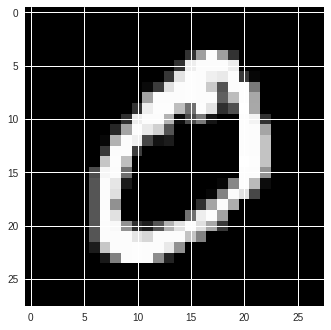

In [0]:
plt.imshow(X_train[1].reshape(28,28).copy(),cmap='gray')

## 6.Show Types of Noise is Generated to Test the Denoising Process

Text(0.5, 1.0, 'Speckle Noise')

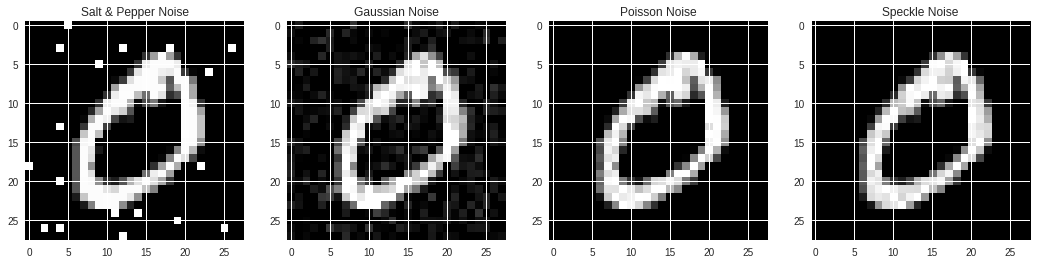

In [0]:
img = X_train[1].reshape(28,28,1).copy()
#noise_img = sp_noise( img, 0.1) 
noise_img_sp = random_noise(img, mode='s&p')
noise_img_gaussian = random_noise(img, mode='gaussian')
noise_img_poisson = random_noise(img, mode='poisson')
noise_img_speckle = random_noise(img, mode='speckle')

fig = plt.figure(figsize=(18, 18))

plt.subplot(1, 4, 1)
plt.imshow(noise_img_sp.reshape(28,28).copy(), cmap = 'gray', interpolation = 'none')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Salt & Pepper Noise')

plt.subplot(1, 4, 2)
plt.imshow(noise_img_gaussian.reshape(28,28).copy(), cmap = 'gray', interpolation = 'none')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Gaussian Noise')

plt.subplot(1, 4, 3)
plt.imshow(noise_img_poisson.reshape(28,28).copy(), cmap = 'gray', interpolation = 'none')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Poisson Noise')

plt.subplot(1, 4, 4)
plt.imshow(noise_img_speckle.reshape(28,28).copy(), cmap = 'gray', interpolation = 'none')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Speckle Noise')

## 7.Apply the Noise Generator Function On Dataset

In [0]:
import random
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()

for i in range(0, X_train_noisy.shape[0]):
    img = X_train_noisy[i].reshape(28, 28, 1).copy()
    rnd = random.randint(1, 4)
    if rnd == 1:
         noise_image = random_noise(img, mode = 's&p')
    elif rnd == 2:
         noise_image = random_noise(img, mode = 'gaussian')
    elif rnd == 3:
         noise_image = random_noise(img, mode = 'poisson')
    elif rnd == 4:
         noise_image = random_noise(img, mode = 'speckle')
    X_train_noisy[i] = noise_image.reshape(28, 28).copy()
    
for i in range(0, X_test_noisy.shape[0]):
    img = X_test_noisy[i].reshape(28, 28, 1).copy()
    rnd = random.randint(1, 4)
    if rnd == 1:
         noise_image = random_noise(img, mode = 's&p')
    elif rnd == 2:
         noise_image = random_noise(img, mode = 'gaussian')
    elif rnd == 3:
         noise_image = random_noise(img, mode = 'poisson')
    elif rnd == 4:
         noise_image = random_noise(img, mode = 'speckle')
    X_test_noisy[i] = noise_image.reshape(28, 28).copy()
    
print(X_train_noisy.shape)
print(X_test_noisy.shape)
    

(60000, 28, 28)
(10000, 28, 28)


## 8.Plot the instance Noisy image in MNIST dataset

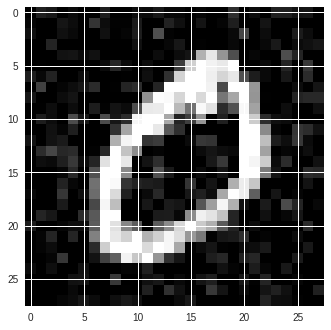

In [0]:
plt.imshow(X_train_noisy[1].reshape(28,28),cmap='gray')

## 9.import keras library

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten,Input,UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import SGD
from keras import backend as K



**AutoٍEncoder is an approach that reduces image noise and removes it by converting the image into a higher-integrity image in the encoding step, and then using the image recovery to the original dimensions from the output of the previous step in the decoding step.**

**This is just one of AutoEncoder applications**

## 10.Encode Model

In [0]:
input_img = Input(shape=(28, 28, 1)) # 1ch=black&white, 28 x 28

x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

print ("shape of encoded" , K.int_shape(encoded))

shape of encoded (None, 4, 4, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same

## 11.Decode Model

In [0]:
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)

# In original tutorial, border_mode='same' was used. 
# then the shape of 'decoded' will be 32 x 32, instead of 28 x 28
# x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x) 
x = Convolution2D(64, 3, 3, activation='relu', border_mode='valid')(x) 

x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 5, 5, activation='sigmoid', border_mode='same')(x)
print ("shape of decoded", K.int_shape(decoded))

shape of decoded (None, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="valid")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="sigmoid", padding="same")`
  if sys.path[0] == '':


## 12.Model Compile

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=SGD(lr=0.001, 
                    momentum=0.9, 
                    nesterov=True),
              loss='binary_crossentropy',
              metrics =['accuracy'])

In [0]:
print(X_train_noisy.shape)
print(X_test_noisy.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train_noisy = X_train_noisy.reshape(60000,28,28,1)
X_test_noisy = X_test_noisy.reshape(10000,28,28,1)

## 13.Model Fit

In [0]:
hist = autoencoder.fit(X_train_noisy, X_train,
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_noisy, X_test), verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 535s 9ms/step - loss: 0.2589 - acc: 0.7964 - val_loss: 0.1824 - val_acc: 0.7960
Epoch 2/5
60000/60000 [==============================] - 535s 9ms/step - loss: 0.1691 - acc: 0.7987 - val_loss: 0.1574 - val_acc: 0.7993
Epoch 3/5
60000/60000 [==============================] - 532s 9ms/step - loss: 0.1505 - acc: 0.8026 - val_loss: 0.1430 - val_acc: 0.8048
Epoch 4/5
60000/60000 [==============================] - 529s 9ms/step - loss: 0.1389 - acc: 0.8051 - val_loss: 0.1333 - val_acc: 0.8045
Epoch 5/5
60000/60000 [==============================] - 535s 9ms/step - loss: 0.1314 - acc: 0.8067 - val_loss: 0.1271 - val_acc: 0.8067


## 14.Plot Accuracy Graph

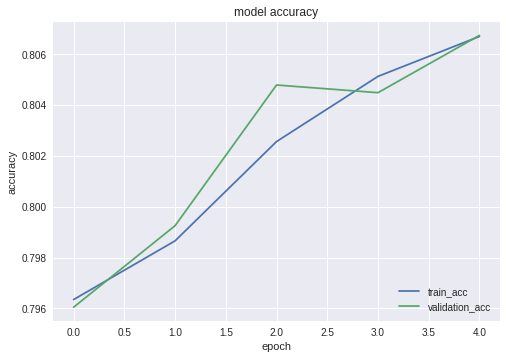

In [0]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validation_acc'], loc='lower right')
plt.show()

## 15.Plot Loss Graph

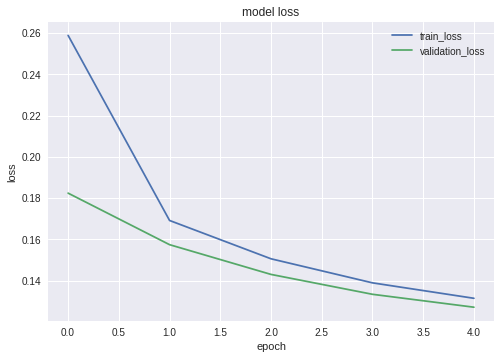

In [0]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.show()

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
__________

## 16.Define the Mid Layer(Z)

In [0]:
layer_name = 'conv2d_3'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                outputs=autoencoder.get_layer(layer_name).output)

## 17.Salt & Pepper Noise Reduction Report

(1, 28, 28, 1)
(1, 7, 7, 32)


Text(0.5, 1.0, 'Salt & Pepper Noise After Noise Reduce')

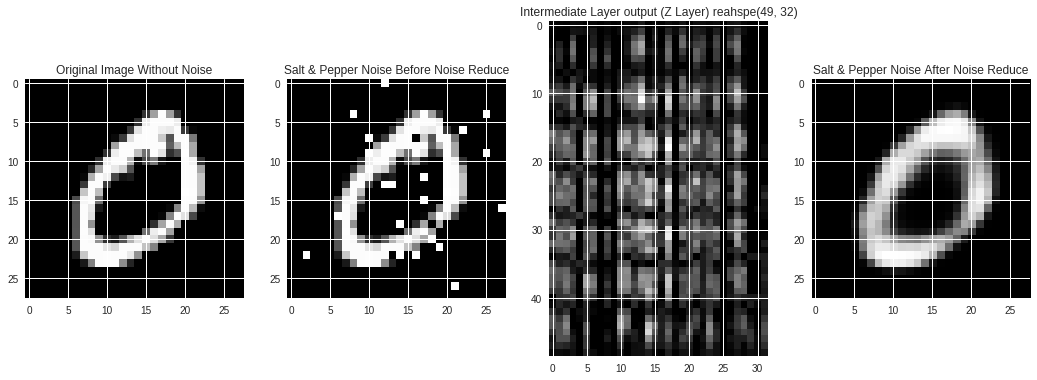

In [0]:
from keras.models import Model


img = X_train[1].reshape(28,28,1).copy()
#noise_img = sp_noise( img, 0.1) 
noise_img_sp = random_noise(img, mode='s&p')

fig = plt.figure(figsize=(18, 18))

out = autoencoder.predict(noise_img_sp.reshape(1, 28, 28, 1).copy())
print(out.shape)
intermediate_output = intermediate_layer_model.predict(noise_img_sp.reshape(1, 28, 28, 1).copy())
print(intermediate_output.shape)

plt.subplot(1, 4, 1)
plt.imshow(img.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Original Image Without Noise')

plt.subplot(1, 4, 2)
plt.imshow(noise_img_sp.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Salt & Pepper Noise Before Noise Reduce')

plt.subplot(1, 4, 3)
plt.imshow(intermediate_output.reshape(49, 32).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Intermediate Layer output (Z Layer) reahspe(49, 32)')

plt.subplot(1, 4, 4)
plt.imshow(out.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Salt & Pepper Noise After Noise Reduce')




## 18.Gaussian Noise Reduction Report

(1, 28, 28, 1)
(1, 7, 7, 32)


Text(0.5, 1.0, 'Gaussian Noise After Noise Reduce')

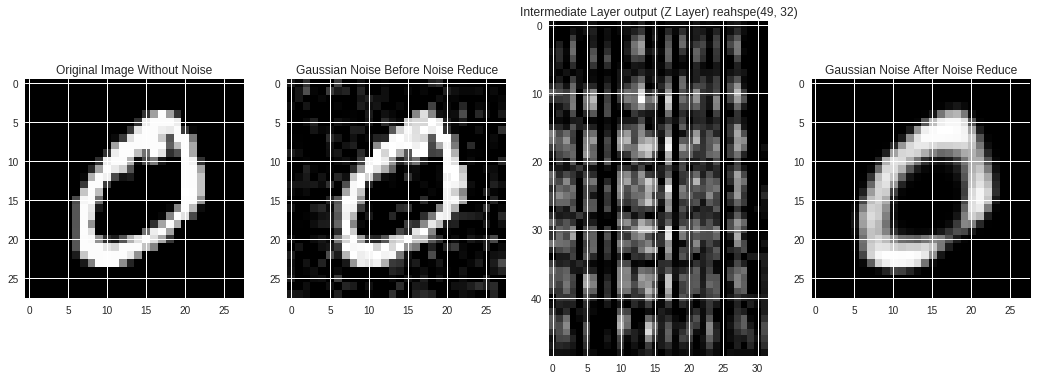

In [0]:
from keras.models import Model


img = X_train[1].reshape(28,28,1).copy()
#noise_img = sp_noise( img, 0.1) 
noise_img_gaussian = random_noise(img, mode='gaussian')

fig = plt.figure(figsize=(18, 18))

out = autoencoder.predict(noise_img_gaussian.reshape(1, 28, 28, 1).copy())
print(out.shape)
intermediate_output = intermediate_layer_model.predict(noise_img_gaussian.reshape(1, 28, 28, 1).copy())
print(intermediate_output.shape)

plt.subplot(1, 4, 1)
plt.imshow(img.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Original Image Without Noise')

plt.subplot(1, 4, 2)
plt.imshow(noise_img_gaussian.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Gaussian Noise Before Noise Reduce')

plt.subplot(1, 4, 3)
plt.imshow(intermediate_output.reshape(49, 32).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Intermediate Layer output (Z Layer) reahspe(49, 32)')

plt.subplot(1, 4, 4)
plt.imshow(out.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Gaussian Noise After Noise Reduce')




## 19.Poisson Noise Reduction Report

(1, 28, 28, 1)
(1, 7, 7, 32)


Text(0.5, 1.0, 'Poisson Noise After Noise Reduce')

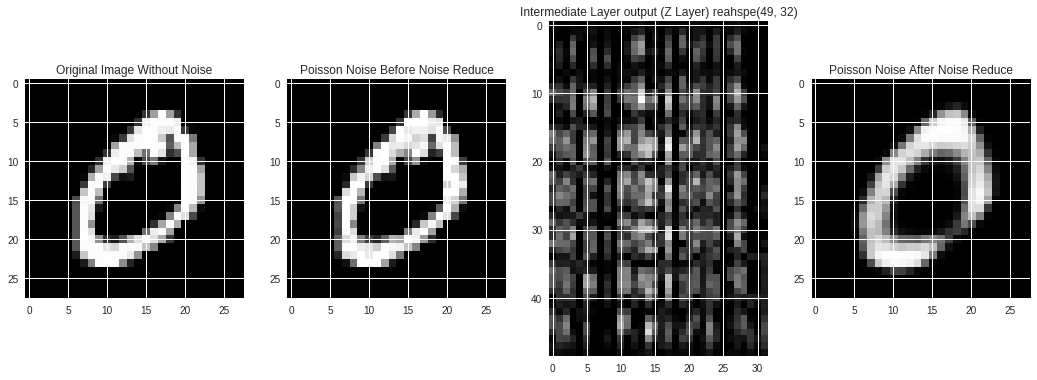

In [0]:
from keras.models import Model


img = X_train[1].reshape(28,28,1).copy()
#noise_img = sp_noise( img, 0.1) 
noise_img_poisson = random_noise(img, mode='poisson')

fig = plt.figure(figsize=(18, 18))

out = autoencoder.predict(noise_img_poisson.reshape(1, 28, 28, 1).copy())
print(out.shape)
intermediate_output = intermediate_layer_model.predict(noise_img_poisson.reshape(1, 28, 28, 1).copy())
print(intermediate_output.shape)

plt.subplot(1, 4, 1)
plt.imshow(img.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Original Image Without Noise')

plt.subplot(1, 4, 2)
plt.imshow(noise_img_poisson.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Poisson Noise Before Noise Reduce')

plt.subplot(1, 4, 3)
plt.imshow(intermediate_output.reshape(49, 32).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Intermediate Layer output (Z Layer) reahspe(49, 32)')

plt.subplot(1, 4, 4)
plt.imshow(out.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Poisson Noise After Noise Reduce')



## 20.Speckle Noise Reduction Report

(1, 28, 28, 1)
(1, 7, 7, 32)


Text(0.5, 1.0, 'Speckle Noise After Noise Reduce')

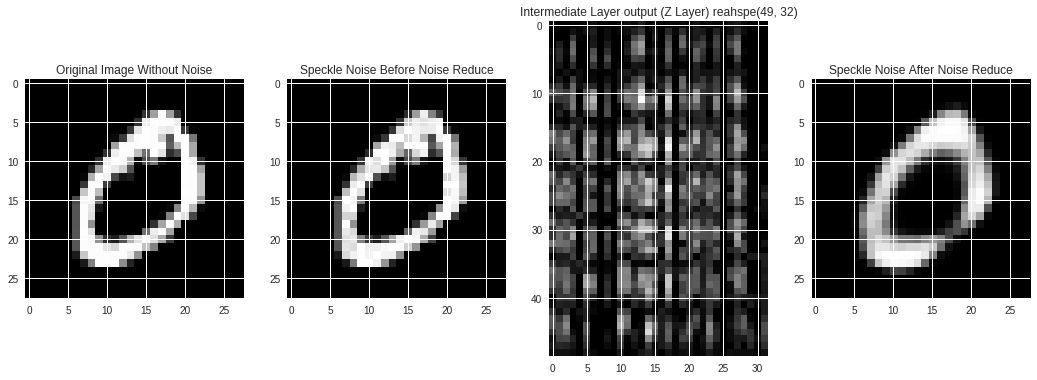

In [0]:
from keras.models import Model


img = X_train[1].reshape(28,28,1).copy()
#noise_img = sp_noise( img, 0.1) 
noise_img_speckle = random_noise(img, mode='speckle')

fig = plt.figure(figsize=(18, 18))

out = autoencoder.predict(noise_img_speckle.reshape(1, 28, 28, 1).copy())
print(out.shape)
intermediate_output = intermediate_layer_model.predict(noise_img_gaussian.reshape(1, 28, 28, 1).copy())
print(intermediate_output.shape)

plt.subplot(1, 4, 1)
plt.imshow(img.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Original Image Without Noise')

plt.subplot(1, 4, 2)
plt.imshow(noise_img_speckle.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Speckle Noise Before Noise Reduce')

plt.subplot(1, 4, 3)
plt.imshow(intermediate_output.reshape(49, 32).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Intermediate Layer output (Z Layer) reahspe(49, 32)')

plt.subplot(1, 4, 4)
plt.imshow(out.reshape(28,28).copy(), cmap = 'gray')
plt.subplots_adjust(hspace = 0.9, wspace = 0.2)
plt.title('Speckle Noise After Noise Reduce')
